(73740, 51661)
834


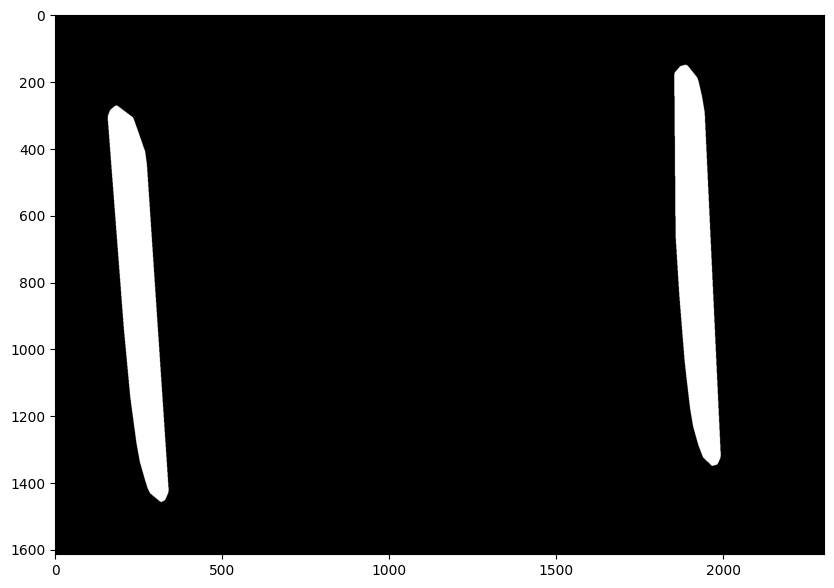

In [8]:
import cv2
import tiffslide as openslide
import numpy as np

import logging 

class Slide:
    def __init__(self, config, svsName) -> None:
        self.config = config
        self.svsName = svsName
        self.svsPath = f"{self.config['svsBase']}/{self.svsName}"
        self.s = openslide.open_slide(self.svsPath)

    def smoothBinary(self, mask):
        kn = 2
        iterat = 2
        kernel = np.ones((kn, kn), np.uint8) 
        for _ in range(iterat):
            mask = cv2.erode(mask, kernel, iterations=1) 
            mask = cv2.dilate(mask, kernel, iterations=1) 
        return mask

    def extractForeground(self):
        location = (0,0)
        level = self.s.level_count-1
        size = self.s.level_dimensions[self.s.level_count-1]
        lr = np.array(self.s.read_region(location, level, size))[:,:,:3]

        lrGray = cv2.cvtColor(lr, cv2.COLOR_RGB2GRAY)

        _, thre = cv2.threshold(lrGray, 220, 255, cv2.THRESH_BINARY) # THreshold for White
        threTissue = 255-thre

        self.threTissueSmooth = self.smoothBinary(threTissue)

        thresholdArea = 0.7
        contours, _ = cv2.findContours(self.threTissueSmooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        c_max = max(contours, key = cv2.contourArea)
        area_min = cv2.contourArea(c_max) * thresholdArea

        contours_filtered = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > area_min:
                contours_filtered.append(cv2.convexHull(contour, returnPoints=True))

        im_ = lrGray*0

        cv2.drawContours(im_, contours_filtered, -1, 255, -1)

        self.threTissueSmooth = np.copy(im_)
                
        return self.threTissueSmooth

    def extractPatches(self, patchSize):
        (w, h) = self.s.level_dimensions[0]
        wn = w//patchSize
        hn = h//patchSize
        self.threTissueSmoothResized = cv2.resize(self.threTissueSmooth, (wn, hn)) # Resize Binary Mask to align with Patches

        self.patches = {}

        for ix in range(wn):
            for iy in range(hn):
                if self.threTissueSmoothResized[iy, ix]==255:
                    try:
                        x = ix*patchSize
                        y = iy*patchSize
                        size = (patchSize, patchSize)
                        level = 0
                        location = (x,y)
                        self.patches[f'{x}_{y}'] = cv2.cvtColor(np.array(self.s.read_region(location, level, size))[:,:,:3], cv2.COLOR_RGB2BGR)
                    except:
                        logging.warning("Exception inside patch extraction")
        
        return self.patches

slideName = '31-10001_PAS_2of2.svs'
patchSize = 512

config = {
    'svsBase': '/blue/pinaki.sarder/nlucarelli/kpmp_new',
    'patchSize': 512
}

slide = Slide(config, slideName)

w, h = slide.s.level_dimensions[0]

fg = slide.extractForeground()

slide.extractPatches(patchSize)

print((w, h))

print(len(slide.patches))

import matplotlib.pyplot as plt

%matplotlib inline

keys = list(slide.patches)

fig = plt.figure(figsize = (20,7))

plt.imshow(fg, cmap='gray')





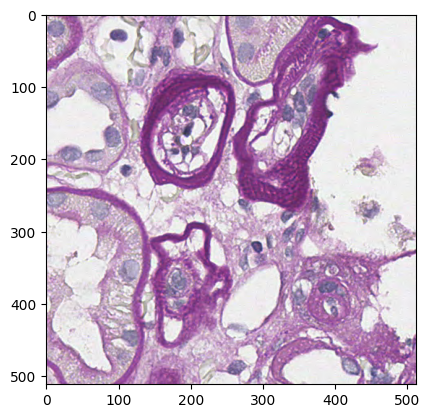

In [9]:
im = cv2.cvtColor(slide.patches[keys[70]], cv2.COLOR_BGR2RGB)

plt.imshow(im)


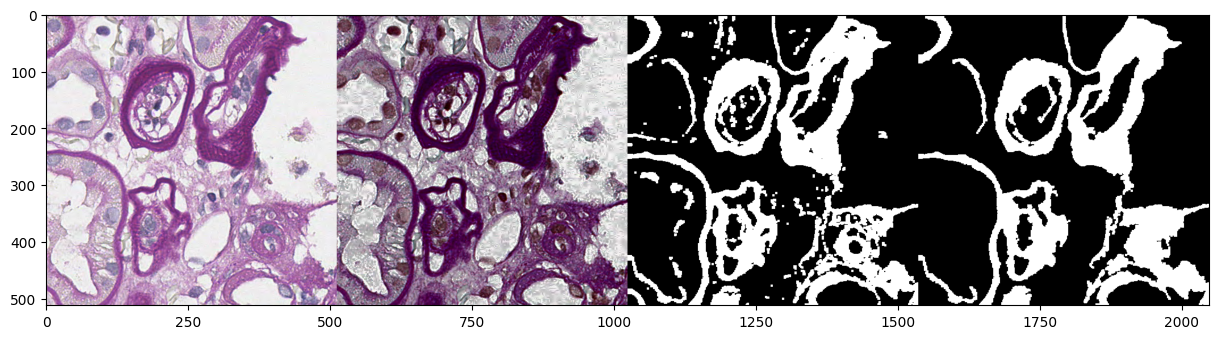

In [20]:
import histomicstk as htk

def applyThreshold(patch):
    hue_min = int(280 * 180/360)
    hue_max = int(320 * 180/360)
    val_min = 0
    val_max = 255
    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
    lower_white = np.array([hue_min,0,val_min], dtype=np.uint8)
    upper_white = np.array([hue_max,255,val_max], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_white, upper_white)
    return mask  

def applyThresholdEosin(patch):
    lower = 200
    upper = 255
    mask = cv2.inRange(patch, lower, upper)
    
    return np.array(255-mask, dtype='uint8')

def smoothBinary(mask):
    kn = 4
    iterat = 6
    kernel = np.ones((kn, kn), np.uint8) 
    for _ in range(iterat):
        mask = cv2.erode(mask, kernel, iterations=1) 
        mask = cv2.dilate(mask, kernel, iterations=1) 
    return mask

def stainDeconv(im):
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    #print('stain_color_map:', stain_color_map, sep='\n')

    # specify stains of input image
    stains = ['hematoxylin',  # nuclei stain
                'eosin',        # cytoplasm stain
                'null']         # set to null if input contains only two stains

    # create stain matrix
    W = np.array([stain_color_map[st] for st in stains]).T

    # perform standard color deconvolution
    imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(im, W)

    ## Thresholding
    eosinStain = imDeconvolved.Stains[:, :, 1]

    return eosinStain


thresholdArea = 0.02


imgYuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
imgYuv[:,:,0] = cv2.equalizeHist(imgYuv[:,:,0])
imEquBGR = cv2.cvtColor(imgYuv, cv2.COLOR_YUV2BGR)

eosin = stainDeconv(imEquBGR)

mask = applyThresholdEosin(eosin)
maskSmooth = smoothBinary(mask)
mask3d = cv2.cvtColor(maskSmooth, cv2.COLOR_GRAY2RGB)
eosin3 = cv2.cvtColor(eosin, cv2.COLOR_GRAY2RGB)

#contours, _ = cv2.findContours(maskSmooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours, _ = cv2.findContours(maskSmooth, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

c_max = max(contours, key = cv2.contourArea)
area_min = cv2.contourArea(c_max) * thresholdArea

contours_filtered = []

for contour in contours:
    area = cv2.contourArea(contour)
    if area > area_min:
        contours_filtered.append(contour)

im_ = im*0

cv2.drawContours(im_, contours_filtered, -1, (255, 255, 255), -1)

imEquBGR = cv2.cvtColor(imEquBGR, cv2.COLOR_BGR2RGB)
concat = cv2.hconcat((im, imEquBGR, mask3d, im_))

fig = plt.figure(figsize = (15,5))

plt.imshow(concat)


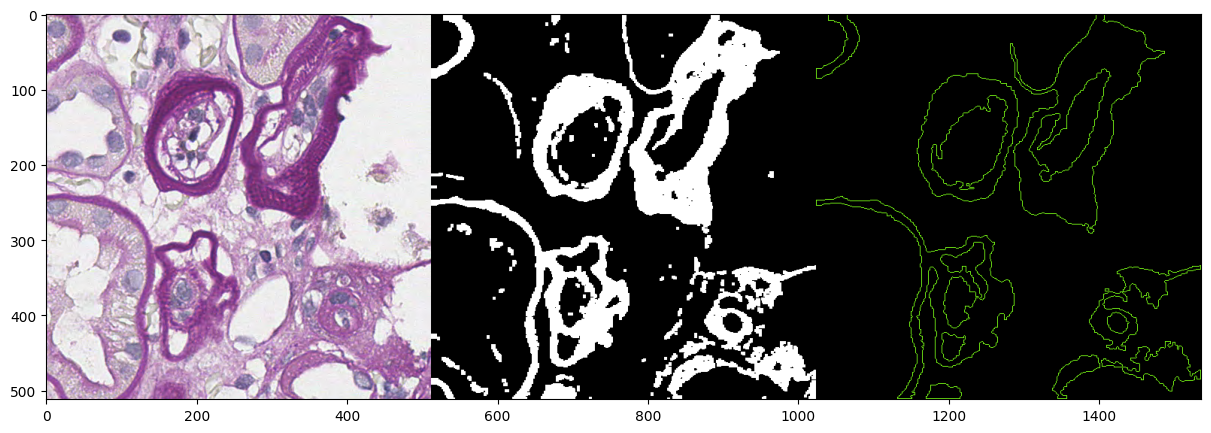

In [7]:
im_ = im*0

cv2.drawContours(im_, contours_filtered, -1, (123, 255, 23), 1)

concat = cv2.hconcat((im, mask3d, im_))

fig = plt.figure(figsize = (15,5))

plt.imshow(concat)
